In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from prophet import Prophet
from prophet.plot import plot_plotly
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series-forecasting/oil.csv
/kaggle/input/time-series-forecasting/sample_submission.csv
/kaggle/input/time-series-forecasting/holidays_events.csv
/kaggle/input/time-series-forecasting/stores.csv
/kaggle/input/time-series-forecasting/train.csv
/kaggle/input/time-series-forecasting/test.csv
/kaggle/input/time-series-forecasting/transactions.csv


# Data Understanding


In [13]:
df = pd.read_csv('/kaggle/input/time-series-forecasting/train.csv')
df.tail()


,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [14]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [15]:
df.shape

(3000888, 6)

In [16]:
df.describe

<bound method NDFrame.describe of               id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE     0.000   
1              1  2013-01-01          1                   BABY CARE     0.000   
2              2  2013-01-01          1                      BEAUTY     0.000   
3              3  2013-01-01          1                   BEVERAGES     0.000   
4              4  2013-01-01          1                       BOOKS     0.000   
...          ...         ...        ...                         ...       ...   
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.0

In [17]:
df.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

# Data Preparation


In [18]:
#Identifying duplicated columns
df.duplicated().sum()


0

In [19]:
#Renaming Columns
df['date'] = pd.to_datetime(df['date'])
df = df.rename(columns={'date': 'ds',
                        'sales': 'y'})


# Feature understanding



In [20]:
df['y'].value_counts()

0.000       939130
1.000       115291
2.000        85959
3.000        68575
4.000        57846
             ...  
116.541          1
363.533          1
141.322          1
409.879          1
2419.729         1
Name: y, Length: 379610, dtype: int64

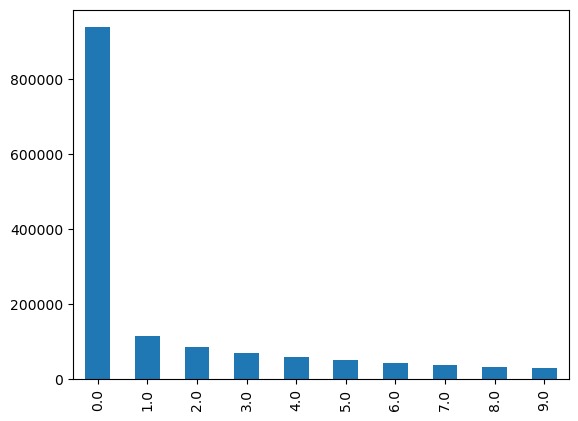

In [21]:
ax = df['y'].value_counts() \
    .head(10) \
    .plot(kind='bar')

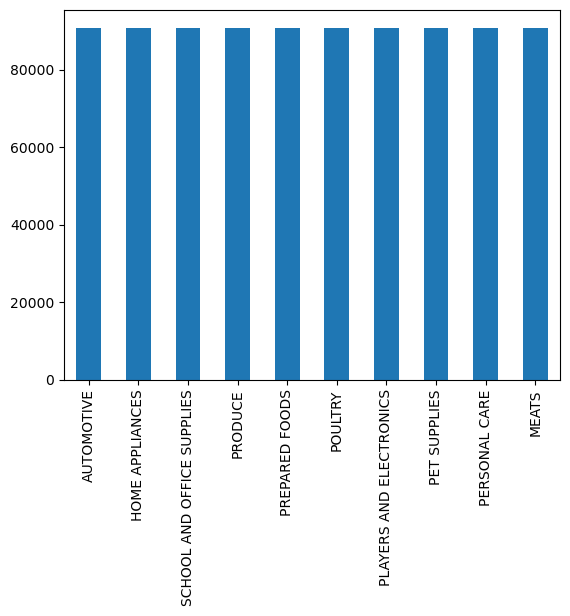

In [22]:
ax = df['family'].value_counts() \
    .head(10) \
    .plot(kind='bar')

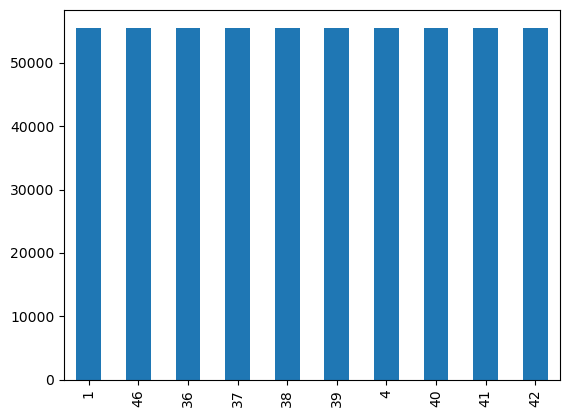

In [23]:
ax = df['store_nbr'].value_counts() \
    .head(10) \
    .plot(kind='bar')

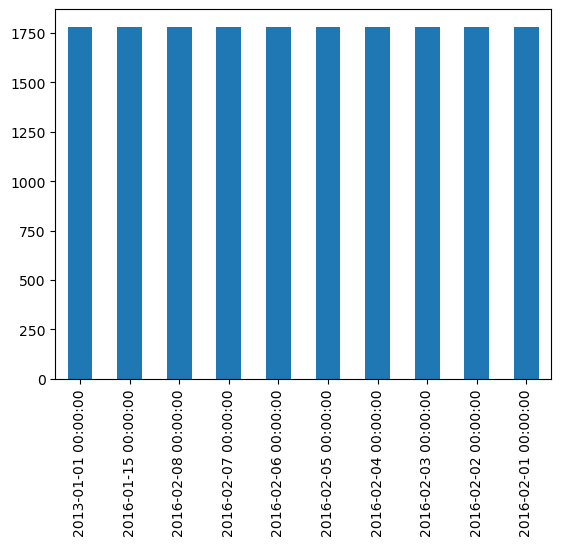

In [24]:
ax = df['ds'].value_counts() \
    .head(10) \
    .plot(kind='bar')

# Feature Relationships

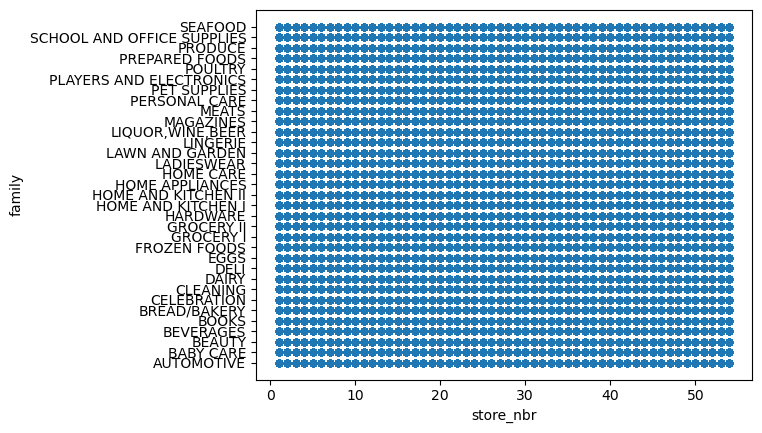

In [25]:
df.plot(kind='scatter',
       y='family',
       x='store_nbr')
plt.show()

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


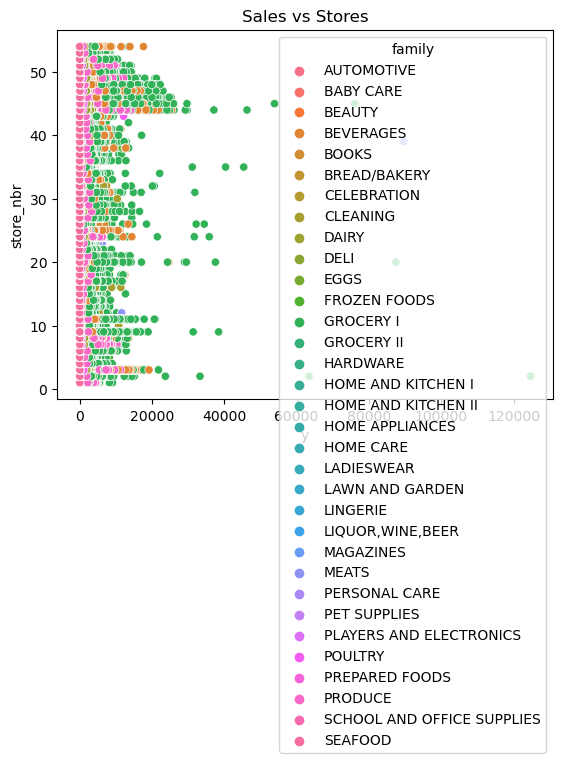

In [26]:
ax = sns.scatterplot(x='y',
                y='store_nbr',
                hue='family',
                data=df)
ax.set_title('Sales vs Stores')
plt.show()

In [27]:
unique_values = df['family'].unique()
unique_values



array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [28]:
data = {'family': ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD']}
df = pd.DataFrame(data)

# Perform one-hot encoding on the 'family' column
encoded_df = pd.get_dummies(df, columns=['family'], prefix=['family'])
encoded_df

,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Concatenate the original DataFrame and the encoded DataFrame
result_df = pd.concat([df, encoded_df], axis=1)

result_df.drop(['AUTOMOTIVE'], axis=0)

# Display the result DataFrame
print(result_df)

KeyError: "['AUTOMOTIVE'] not found in axis"

In [ ]:
result_df.dtypes

# SNS to compare multiple variables

In [ ]:
auto = df[df['family']=='AUTOMOTIVE'].copy()
auto.head()



In [ ]:
columns_to_drop = ['family', 'onpromotion']
auto.drop(columns_to_drop, axis=1, inplace=True)
auto.head()

In [ ]:
m = Prophet(interval_width=0.95)
train_run = m.fit(auto)
future = m.make_future_dataframe(periods=14, freq='D')
forecast = m.predict(future)
forecast.tail()

In [ ]:
plot1 = m.plot(forecast)

In [ ]:
plot2 = m.plot_components(forecast)

In [ ]:
    columns_to_drop = ['family', 'onpromotion']
    product.drop(columns_to_drop, axis=1, inplace=True)
    print(product.tail())
    

In [ ]:
holidays = pd.read_csv('/kaggle/input/time-series-forecasting/holidays_events.csv')
unique_holidays = holidays['date'].unique()
unique_holidays

In [35]:
holidays = holidays.rename(columns={'date': 'ds',
                        'type': 'Holidays'})

holidays = pd.DataFrame({'holiday': 'Holidays',
  'ds': pd.to_datetime(['2012-03-02', '2012-04-01', '2012-04-12', '2012-04-14',
       '2012-04-21', '2012-05-12', '2012-06-23', '2012-06-25',
       '2012-07-03', '2012-07-23', '2012-08-05', '2012-08-10',
       '2012-08-15', '2012-08-24', '2012-09-28', '2012-10-07',
       '2012-10-09', '2012-10-12', '2012-11-02', '2012-11-03',
       '2012-11-06', '2012-11-07', '2012-11-10', '2012-11-11',
       '2012-11-12', '2012-12-05', '2012-12-06', '2012-12-08',
       '2012-12-21', '2012-12-22', '2012-12-23', '2012-12-24',
       '2012-12-25', '2012-12-26', '2012-12-31', '2013-01-01',
       '2013-01-05', '2013-01-12', '2013-02-11', '2013-02-12',
       '2013-03-02', '2013-04-01', '2013-04-12', '2013-04-14',
       '2013-04-21', '2013-04-29', '2013-05-01', '2013-05-11',
       '2013-05-12', '2013-05-24', '2013-06-23', '2013-06-25',
       '2013-07-03', '2013-07-23', '2013-07-24', '2013-07-25',
       '2013-08-05', '2013-08-10', '2013-08-15', '2013-08-24',
       '2013-09-28', '2013-10-07', '2013-10-09', '2013-10-11',
       '2013-11-02', '2013-11-03', '2013-11-06', '2013-11-07',
       '2013-11-10', '2013-11-11', '2013-11-12', '2013-12-05',
       '2013-12-06', '2013-12-08', '2013-12-21', '2013-12-22',
       '2013-12-23', '2013-12-24', '2013-12-25', '2013-12-26',
       '2013-12-31', '2014-01-01', '2014-03-02', '2014-03-03',
       '2014-03-04', '2014-04-01', '2014-04-12', '2014-04-14',
       '2014-04-18', '2014-04-21', '2014-05-01', '2014-05-10',
       '2014-05-11', '2014-05-12', '2014-05-24', '2014-06-12',
       '2014-06-15', '2014-06-20', '2014-06-23', '2014-06-25',
       '2014-06-28', '2014-06-29', '2014-06-30', '2014-07-01',
       '2014-07-03', '2014-07-04', '2014-07-05', '2014-07-08',
       '2014-07-09', '2014-07-12', '2014-07-13', '2014-07-23',
       '2014-07-24', '2014-07-25', '2014-08-05', '2014-08-10',
       '2014-08-15', '2014-08-24', '2014-09-28', '2014-10-07',
       '2014-10-09', '2014-10-10', '2014-11-02', '2014-11-03',
       '2014-11-06', '2014-11-07', '2014-11-10', '2014-11-11',
       '2014-11-12', '2014-11-28', '2014-12-01', '2014-12-05',
       '2014-12-06', '2014-12-08', '2014-12-20', '2014-12-21',
       '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
       '2014-12-26', '2014-12-31', '2015-01-01', '2015-01-02',
       '2015-01-10', '2015-02-16', '2015-02-17', '2015-03-02',
       '2015-04-01', '2015-04-03', '2015-04-12', '2015-04-14',
       '2015-04-21', '2015-05-01', '2015-05-09', '2015-05-10',
       '2015-05-12', '2015-05-24', '2015-06-23', '2015-06-25',
       '2015-07-03', '2015-07-23', '2015-07-24', '2015-07-25',
       '2015-08-05', '2015-08-10', '2015-08-15', '2015-08-24',
       '2015-09-28', '2015-10-07', '2015-10-09', '2015-11-02',
       '2015-11-03', '2015-11-06', '2015-11-07', '2015-11-10',
       '2015-11-11', '2015-11-12', '2015-11-27', '2015-11-30',
       '2015-12-05', '2015-12-06', '2015-12-08', '2015-12-21',
       '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25',
       '2015-12-26', '2015-12-31', '2016-01-01', '2016-02-08',
       '2016-02-09', '2016-03-02', '2016-03-25', '2016-04-01',
       '2016-04-12', '2016-04-14', '2016-04-16', '2016-04-17',
       '2016-04-18', '2016-04-19', '2016-04-20', '2016-04-21',
       '2016-04-22', '2016-04-23', '2016-04-24', '2016-04-25',
       '2016-04-26', '2016-04-27', '2016-04-28', '2016-04-29',
       '2016-04-30', '2016-05-01', '2016-05-02', '2016-05-03',
       '2016-05-04', '2016-05-05', '2016-05-06', '2016-05-07',
       '2016-05-08', '2016-05-09', '2016-05-10', '2016-05-11',
       '2016-05-12', '2016-05-13', '2016-05-14', '2016-05-15',
       '2016-05-16', '2016-05-24', '2016-05-27', '2016-06-23',
       '2016-06-25', '2016-07-03', '2016-07-23', '2016-07-24',
       '2016-07-25', '2016-08-05', '2016-08-10', '2016-08-12',
       '2016-08-15', '2016-08-24', '2016-09-28', '2016-10-07',
       '2016-10-09', '2016-11-02', '2016-11-03', '2016-11-04',
       '2016-11-06', '2016-11-07', '2016-11-10', '2016-11-11',
       '2016-11-12', '2016-11-25', '2016-11-28', '2016-12-05',
       '2016-12-06', '2016-12-08', '2016-12-21', '2016-12-22',
       '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-31', '2017-01-01', '2017-01-02', '2017-02-27',
       '2017-02-28', '2017-03-02', '2017-04-01', '2017-04-12',
       '2017-04-13', '2017-04-14', '2017-04-21', '2017-05-01',
       '2017-05-12', '2017-05-13', '2017-05-14', '2017-05-24',
       '2017-05-26', '2017-06-23', '2017-06-25', '2017-07-03',
       '2017-07-23', '2017-07-24', '2017-07-25', '2017-08-05',
       '2017-08-10', '2017-08-11', '2017-08-15', '2017-08-24',
       '2017-09-28', '2017-09-29', '2017-10-07', '2017-10-09',
       '2017-11-02', '2017-11-03', '2017-11-06', '2017-11-07',
       '2017-11-10', '2017-11-11', '2017-11-12', '2017-12-05',
       '2017-12-06', '2017-12-08', '2017-12-21', '2017-12-22',
       '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-26'])})



14:25:33 - cmdstanpy - INFO - Chain [1] start processing
14:25:53 - cmdstanpy - INFO - Chain [1] done processing
14:26:04 - cmdstanpy - INFO - Chain [1] start processing
14:26:31 - cmdstanpy - INFO - Chain [1] done processing
14:26:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:28 - cmdstanpy - INFO - Chain [1] done processing
14:27:39 - cmdstanpy - INFO - Chain [1] start processing
14:28:39 - cmdstanpy - INFO - Chain [1] done processing
14:28:49 - cmdstanpy - INFO - Chain [1] start processing
14:31:16 - cmdstanpy - INFO - Chain [1] done processing
14:31:27 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] done processing
14:32:13 - cmdstanpy - INFO - Chain [1] start processing
14:33:18 - cmdstanpy - INFO - Chain [1] done processing
14:33:30 - cmdstanpy - INFO - Chain [1] start processing
14:33:45 - cmdstanpy - INFO - Chain [1] done processing
14:33:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:03 - cmdstanpy - INFO - Chain [1]

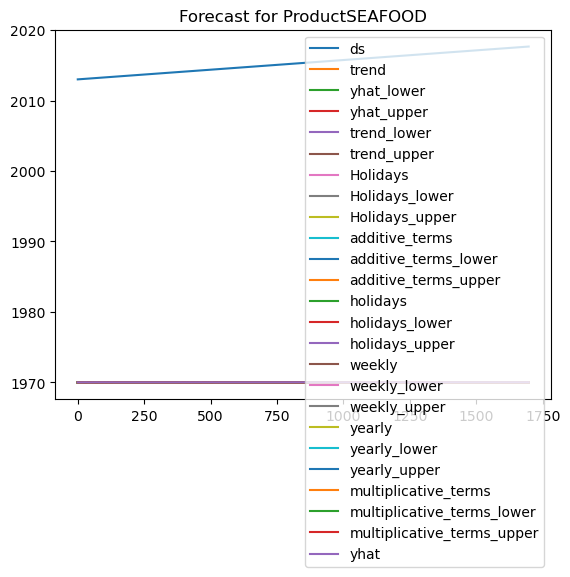

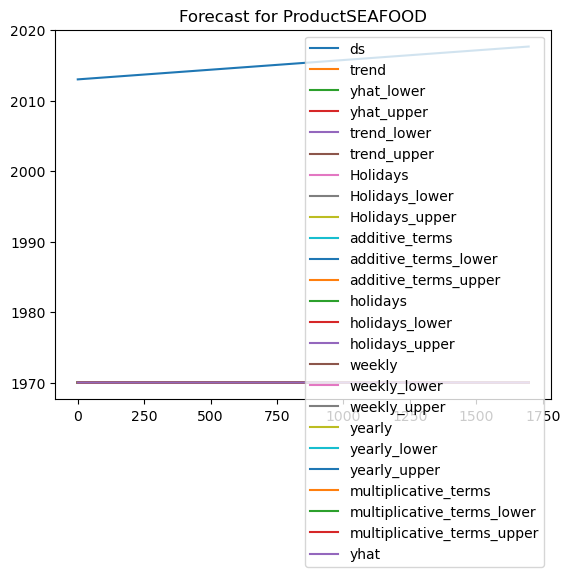

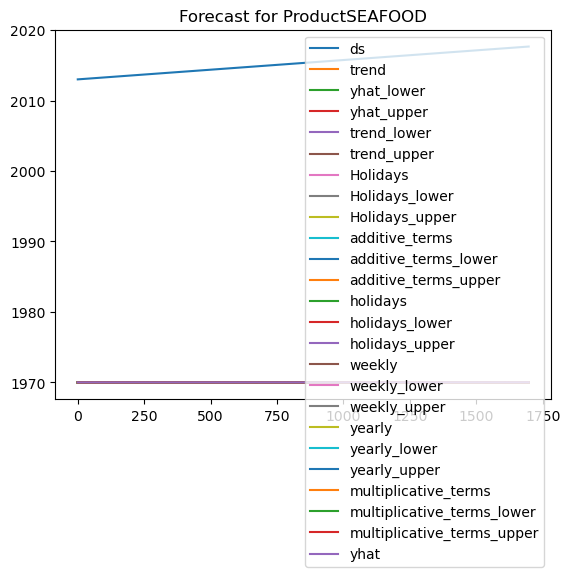

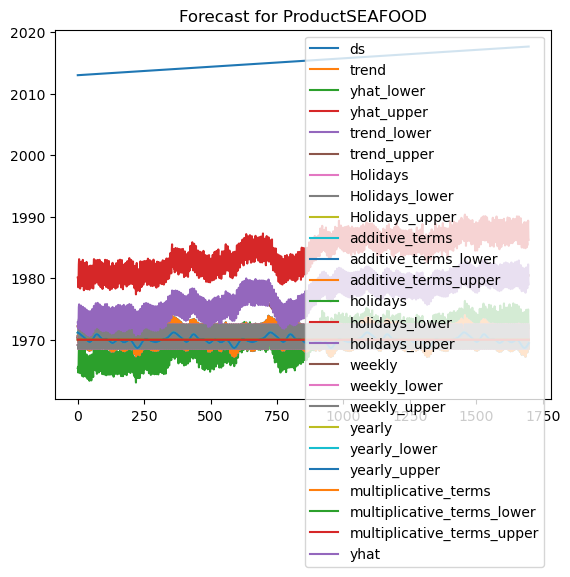

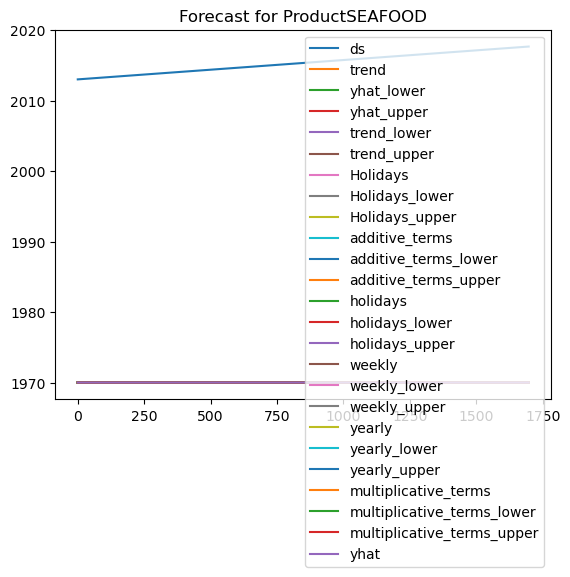

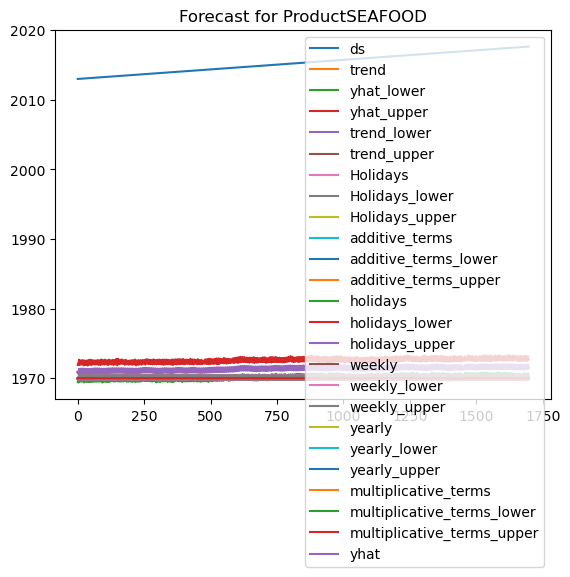

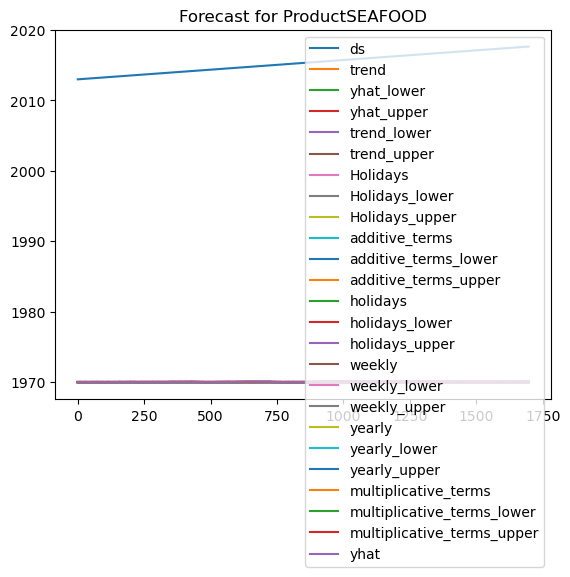

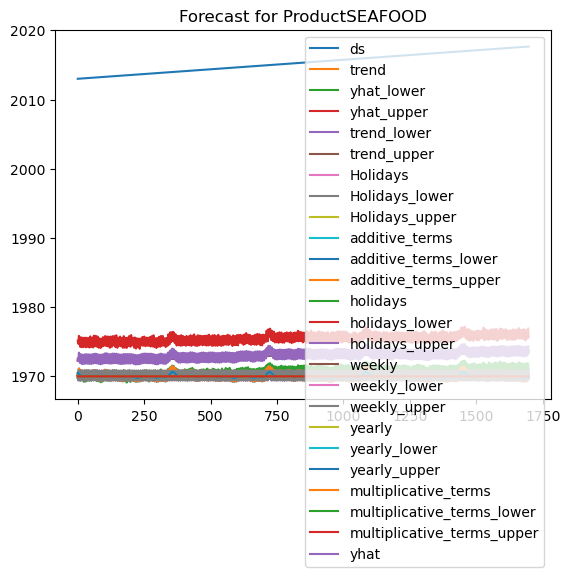

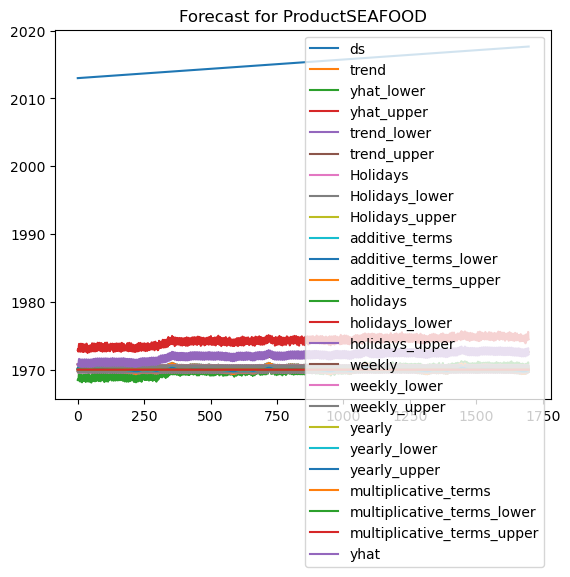

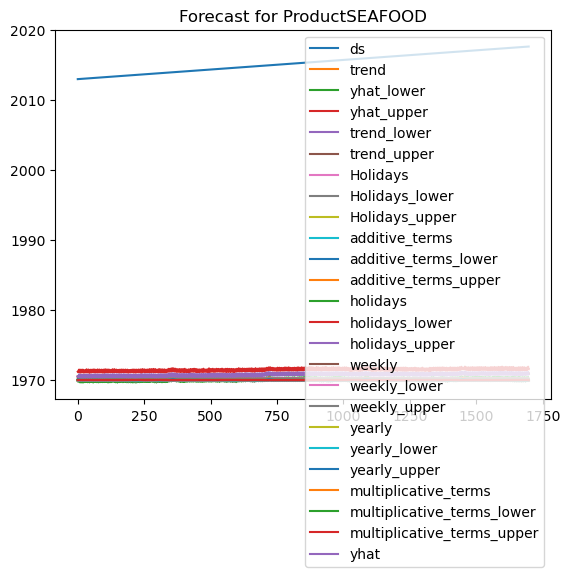

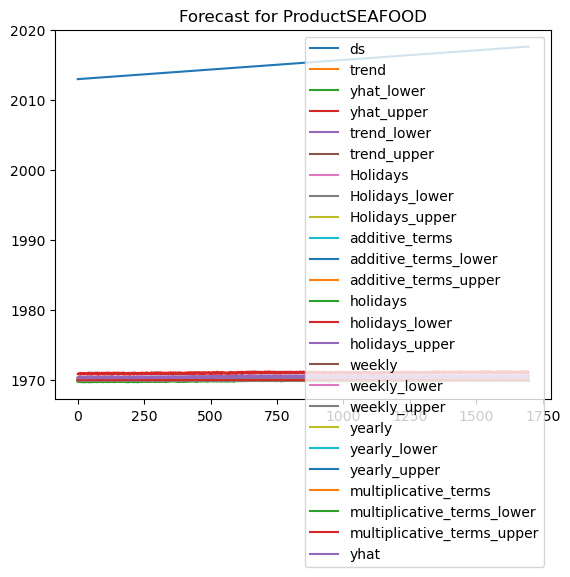

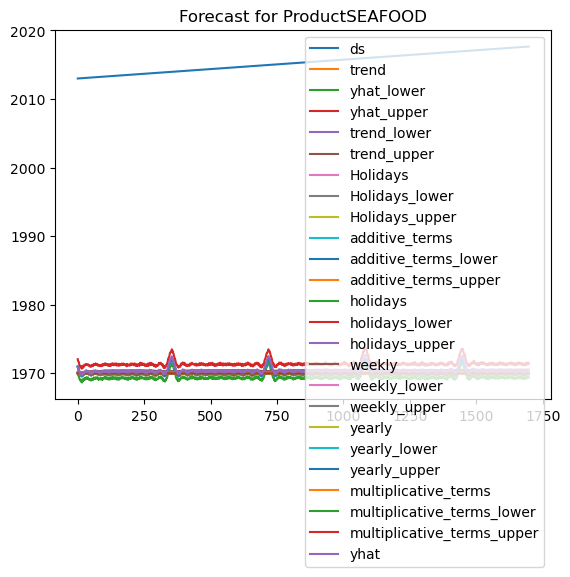

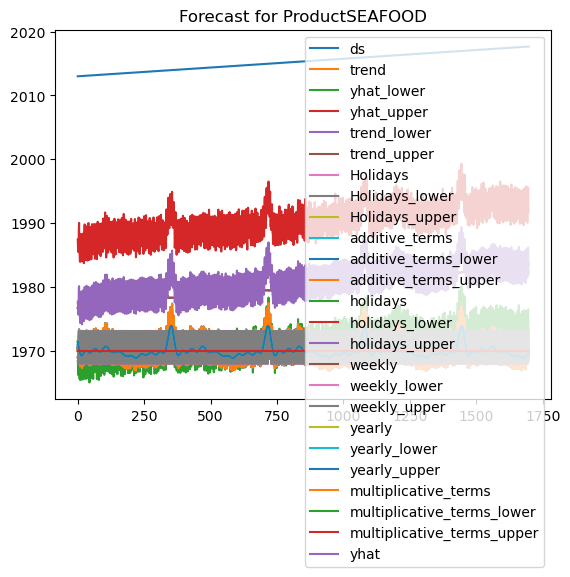

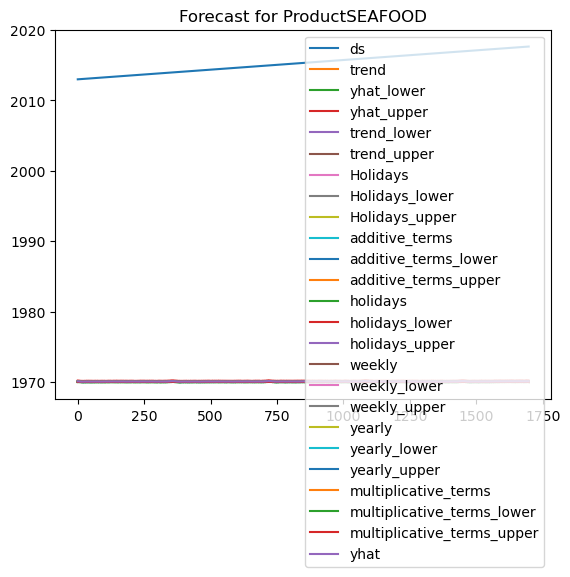

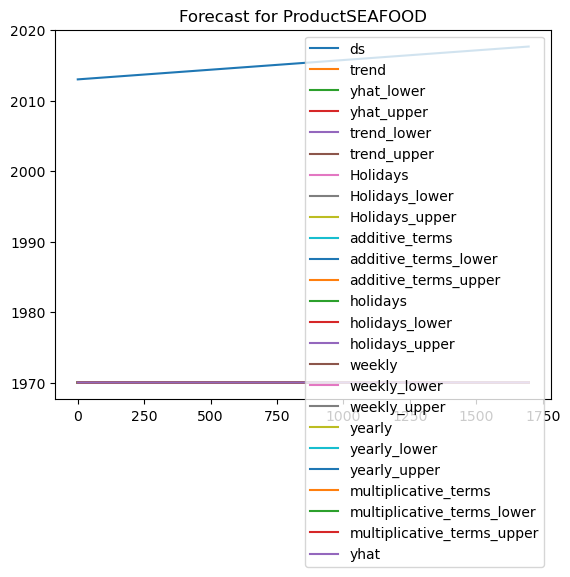

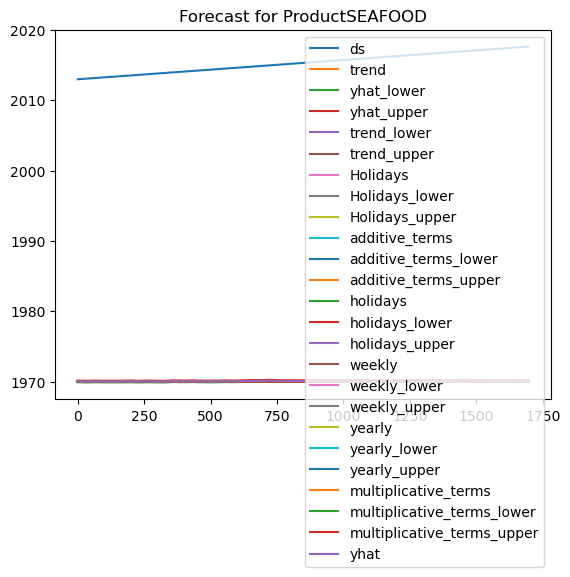

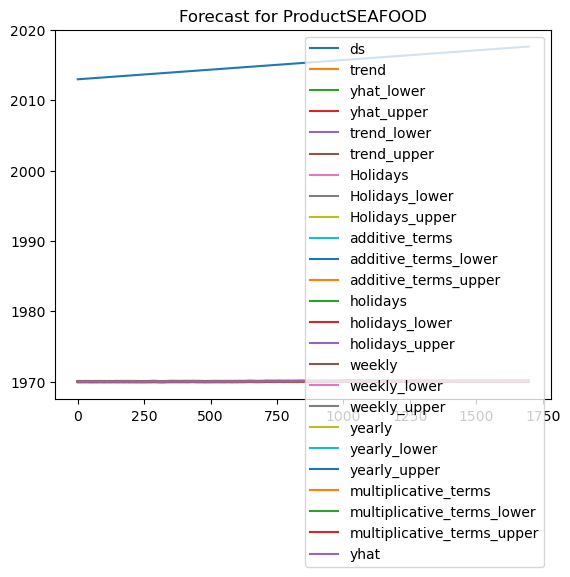

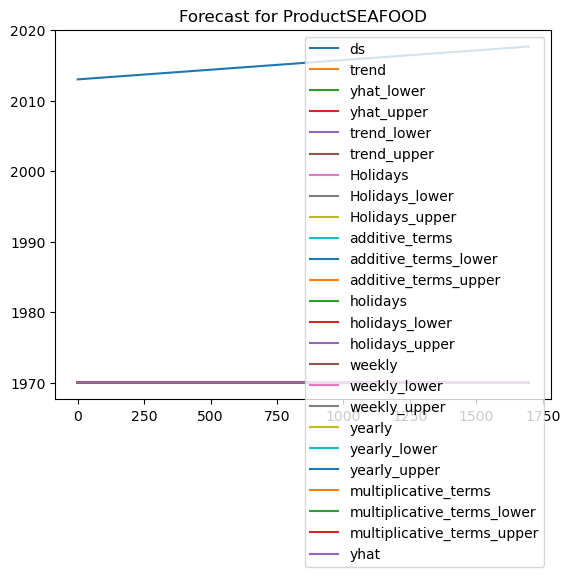

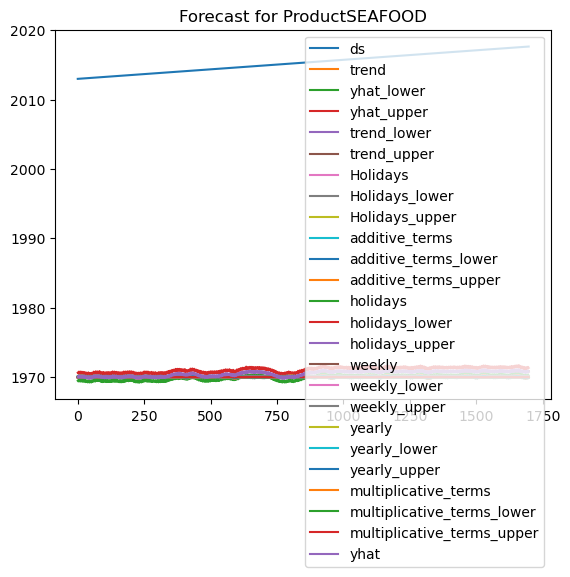

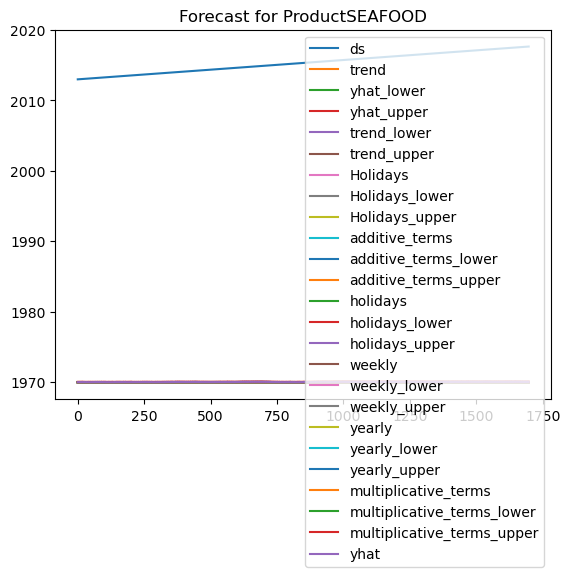

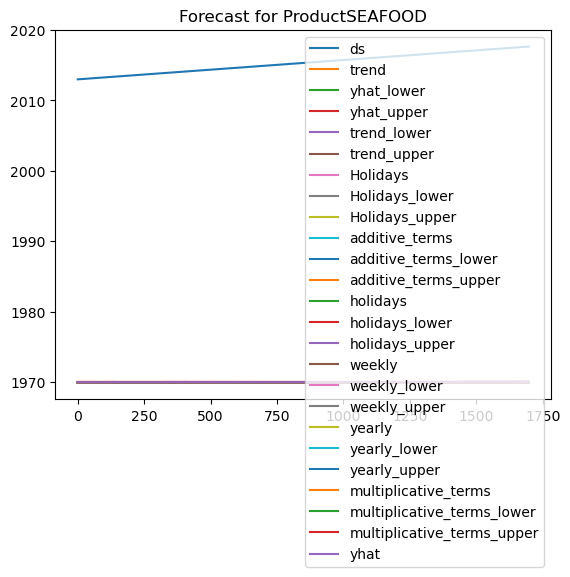

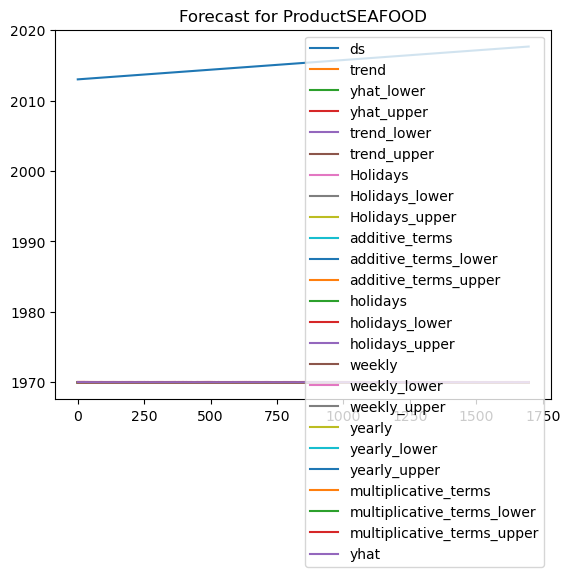

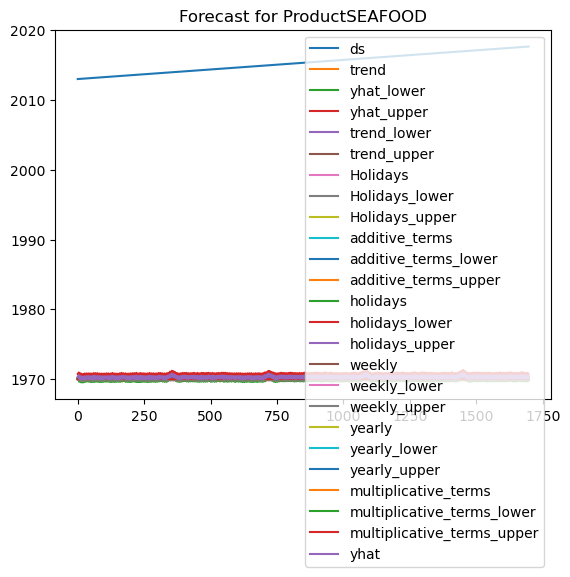

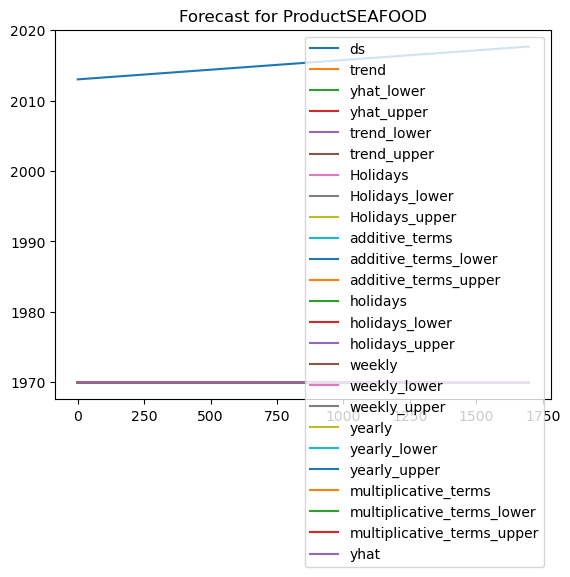

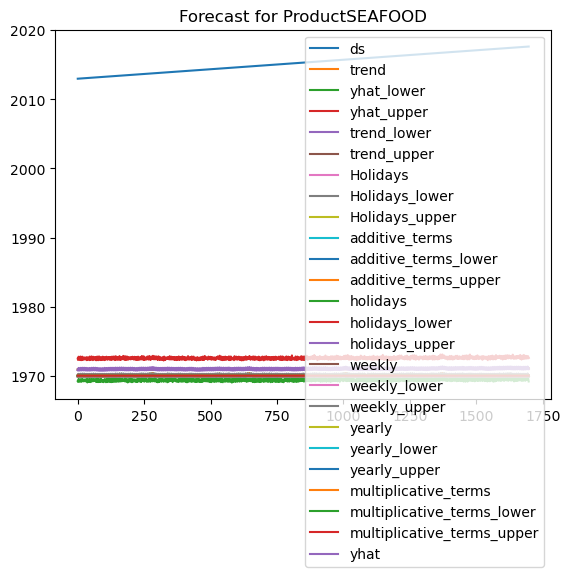

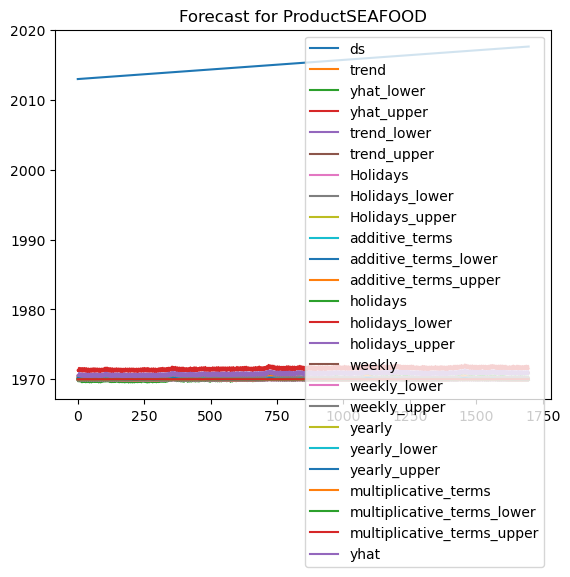

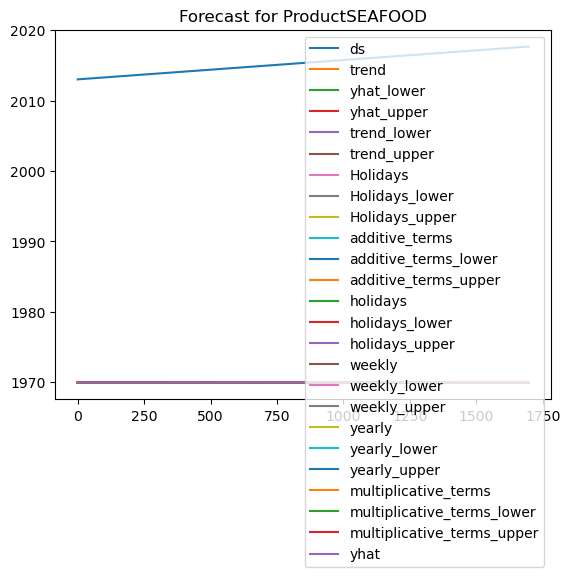

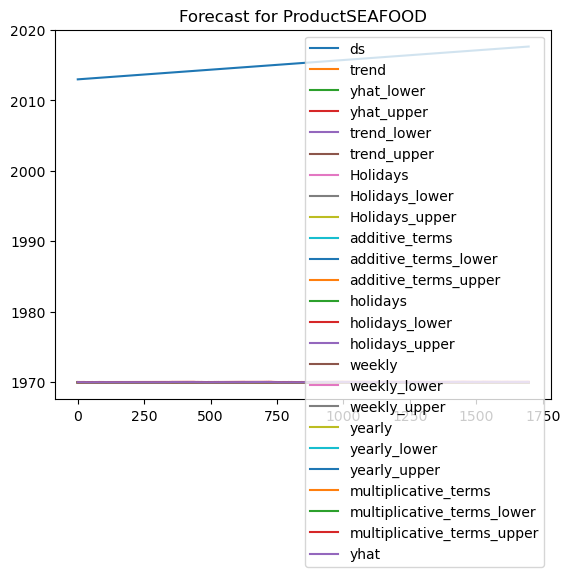

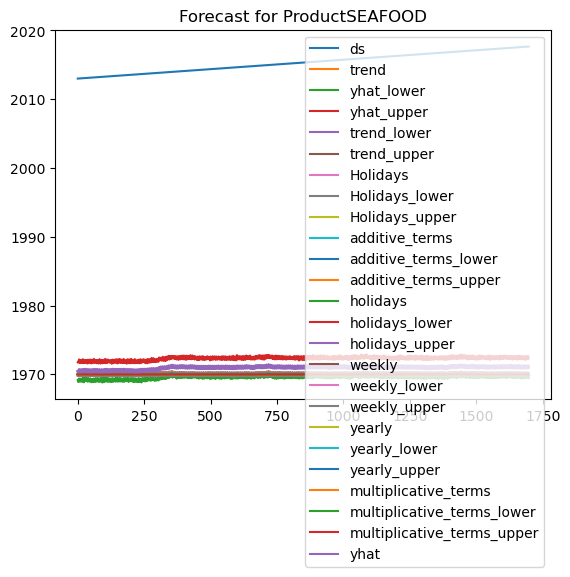

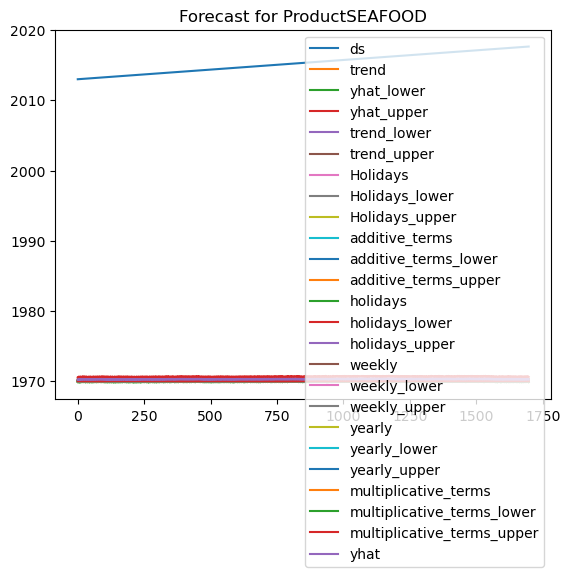

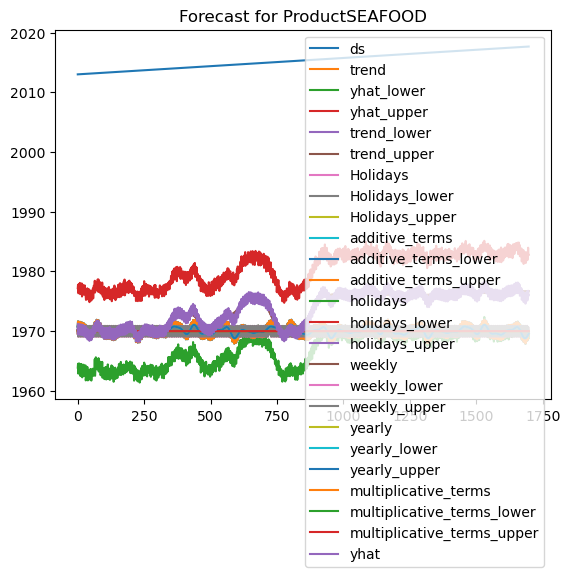

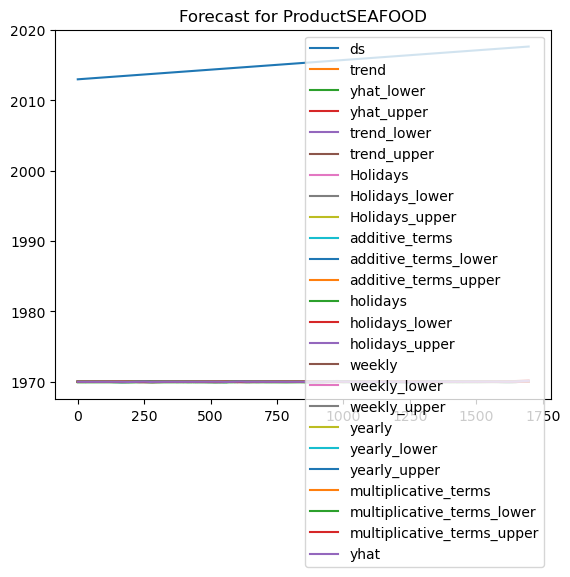

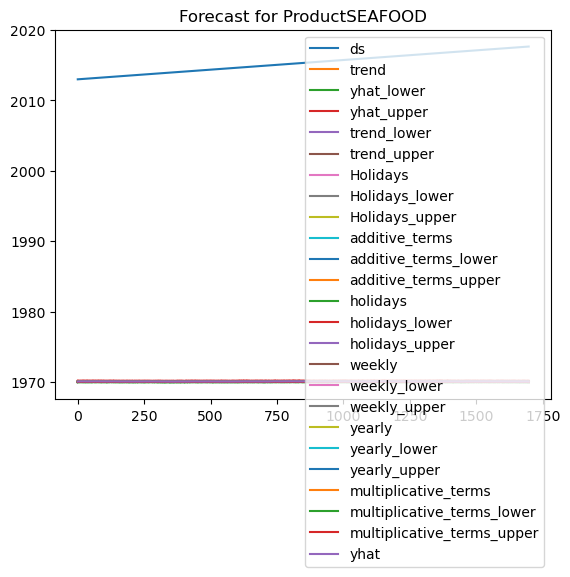

In [40]:
df = pd.read_csv('/kaggle/input/time-series-forecasting/train.csv')
df['date'] = pd.DatetimeIndex(df['date'])
df = df.rename(columns={'date': 'ds',
                        'sales': 'y'})

# List to store the forecasts per store
forecasts_per_product = []

# Extract the 'store_number' column as a pandas Series, removing duplicates in the list
product_series = df['family'].unique()

# Convert the Series to a list using the tolist() method
product_list = sorted(product_series.tolist())

# Loop through each product
for product in product_list:
    # Filter the data for the current store_number
    product_data = df[df['family'] == product].copy()
    
    # Initialize the Prophet model with holidays
    m = Prophet(holidays=holidays)

    # Fit the model
    m.fit(product_data)

    # Make future predictions
    future = m.make_future_dataframe(periods=14, freq='D')
    forecast = m.predict(future)

    # Append the forecast to the list of forecasts
    forecasts_per_product.append(forecast)
   
for forecast in forecasts_per_product:
    # Plot the forecast
    fig = forecast.plot()
    plt.title(f"Forecast for Product{product}")
    plt.show()
    

    
